In [1]:
import cx_Oracle
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib import rc
rc("font", family = "Malgun Gothic")
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, r2_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import mean_squared_error, mean_squared_log_error 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


import warnings
warnings.filterwarnings("ignore")

In [2]:
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [32]:
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label) 
            marker_idx = label % len(markers)
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[marker_idx], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        #axs[ind].legend(loc='upper right')
    
    plt.show()

In [58]:
clusterdata = pd.read_pickle("dataSet/clusterdata.pkl")

In [60]:
column_list = clusterdata.drop(["CAGR", "M", "ABS기타", "ABS가구", "ABS가공" "LABEL"], axis = 1)
column_list.columns

Index(['성별', '연령대', '거주지역', 'A구매여부', 'B구매여부', 'C구매여부', 'D구매여부', '선호제휴사',
       '선호제휴점포', '선호상품1', '선호상품2', '선호상품3', 'R', 'F', 'LABEL', '가공변화', '신선변화',
       '일상변화', '의약변화', '교육변화', '디지털변화', '가구변화', '의류변화', '전문스포츠변화', '패션잡화변화',
       '명품변화', '기타변화', 'ABS신선', 'ABS일상', 'ABS의약', 'ABS교육', 'ABS디지털', 'ABS의류',
       'ABS전문스포츠', 'ABS패션잡화', 'ABS명품'],
      dtype='object')

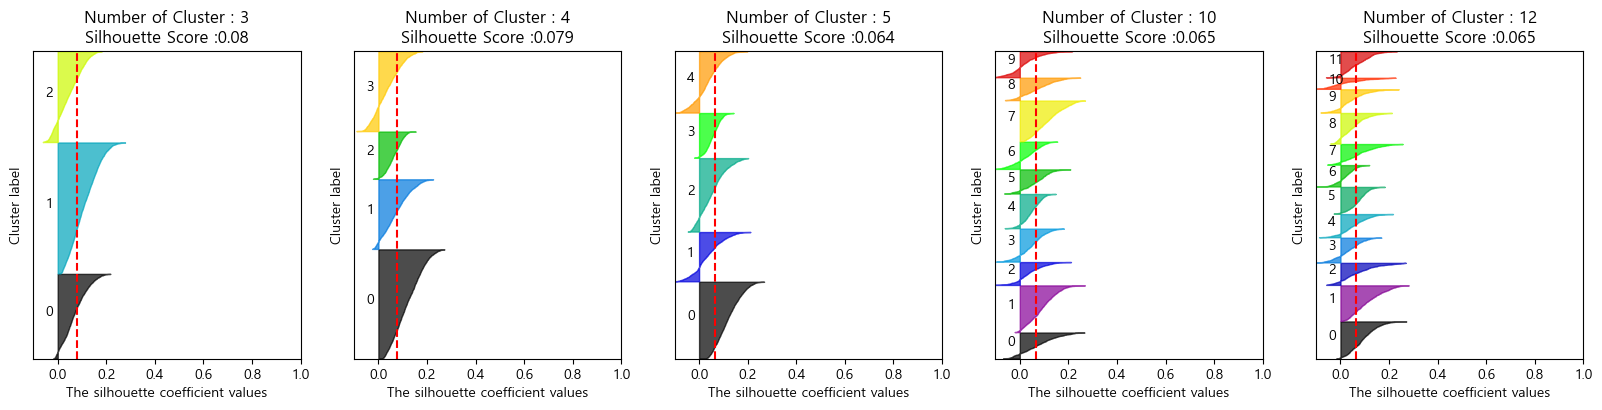

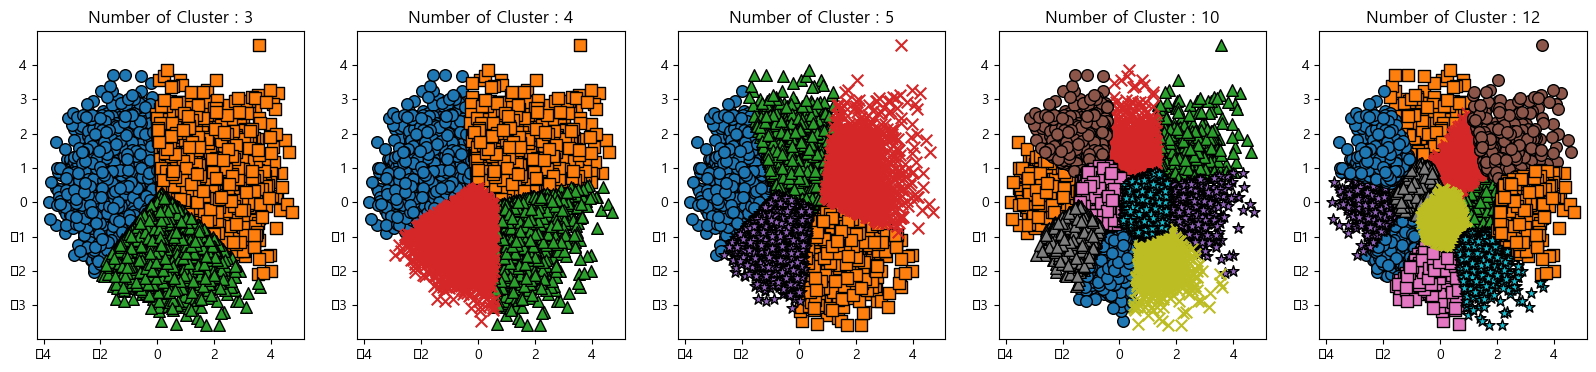

In [71]:
data = clusterdata[clusterdata["LABEL"] == 1]


# 이 부분은 기본 피쳐 부분입니다. 웬만하면 건드리시면 안 됩니다!!
Basic = data[["CAGR", "M", "ABS기타", "ABS가구", "ABS가공"]]
# 이 부분은 기본 피쳐 부분입니다. 웬만하면 건드리시면 안 됩니다!!


#이 부분 수정하시면 됩니다.
Additional = data[["성별","연령대","거주지역", "R", "F", "선호상품1", "선호상품2","기타변화", "가구변화","가공변화"]]
n_cluster = [3,4,5,10,12]
#이 부분 수정하시면 됩니다.




X_features = pd.concat([Basic, Additional], axis = 1)




X_features_scaled = StandardScaler().fit_transform(X_features)

# kmeans = KMeans(n_clusters = 3, random_state = 0)
# labels = kmeans.fit_predict(X_features_scaled)
# data["cluster_label"] = labels



visualize_silhouette(n_cluster, X_features_scaled)
visualize_kmeans_plot_multi(n_cluster, X_features_scaled)

In [73]:
kmeans = KMeans(n_clusters = 3, max_iter=500, random_state=0).fit(X_features)

X_features["cluster"] = kmeans.labels_

In [74]:
X_features

,CAGR,M,ABS기타,ABS가구,ABS가공,성별,연령대,거주지역,R,F,선호상품1,선호상품2,기타변화,가구변화,가공변화,cluster
0,0,0,2,20,6,1,0,7,3,3,4,1,0,0,-6,1
1,0,0,25,34,14,1,0,7,3,3,9,10,-9,0,0,2
3,1,5,29,26,13,0,0,7,7,2,3,10,3,-8,3,2
5,2,3,12,26,9,0,0,0,8,6,11,6,0,6,1,1
9,3,4,12,22,3,0,0,7,8,9,8,6,0,-6,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19356,1,8,16,12,7,0,2,5,5,4,0,8,4,0,-1,2
19358,2,9,4,0,7,1,1,7,5,4,0,6,-4,0,-1,0
19359,3,9,0,0,4,0,1,7,0,0,8,9,0,0,-2,0
19363,3,5,14,0,2,0,3,10,7,2,8,9,-4,0,0,0


In [75]:
cluster0 = X_features[X_features["cluster"] == 0]
cluster1 = X_features[X_features["cluster"] == 1]
cluster2 = X_features[X_features["cluster"] == 2]

In [112]:
def make_pie(df, column):
    count = df[column].value_counts().sort_index()
    index = list(count.index)
    value = list(count)
    
    a = plt.pie(value, labels=index, autopct='%1.1f%%')
    plt.title(f"DataFrame {column} Cluster Pie Chart")

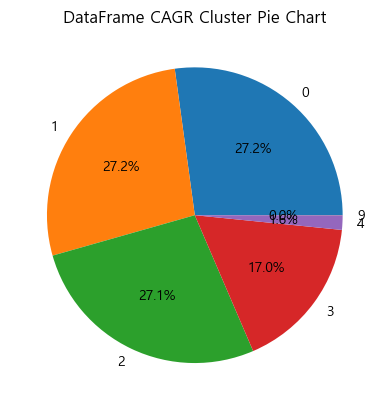

In [113]:
make_pie(X_features, "CAGR")

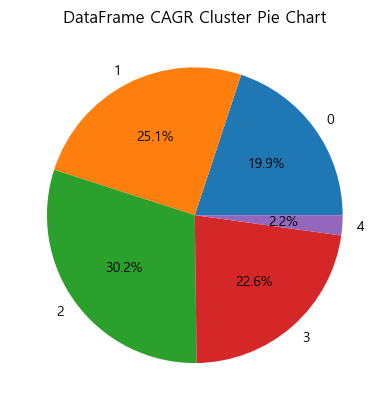

In [114]:
make_pie(cluster0, "CAGR")

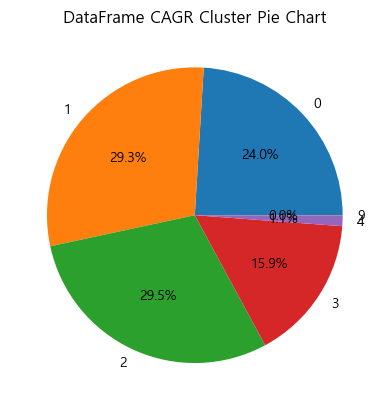

In [115]:
make_pie(cluster1, "CAGR")

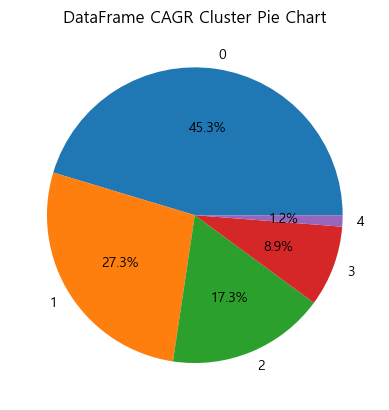

In [116]:
make_pie(cluster2, "CAGR")

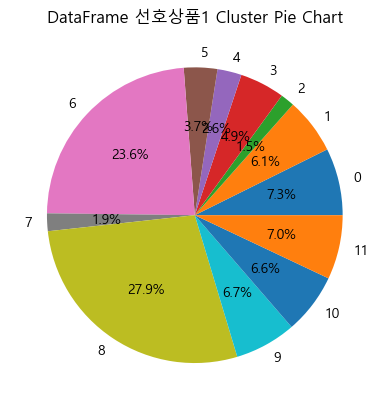

In [117]:
make_pie(X_features, "선호상품1")

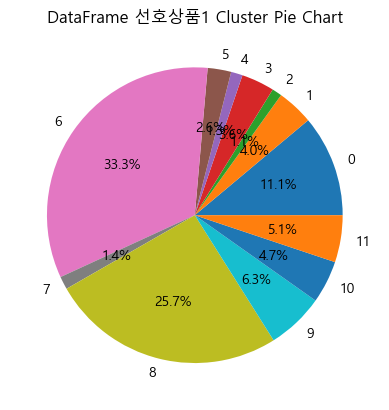

In [118]:
make_pie(cluster0, "선호상품1")

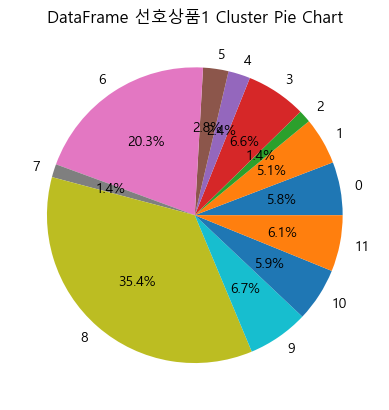

In [119]:
make_pie(cluster1, "선호상품1")

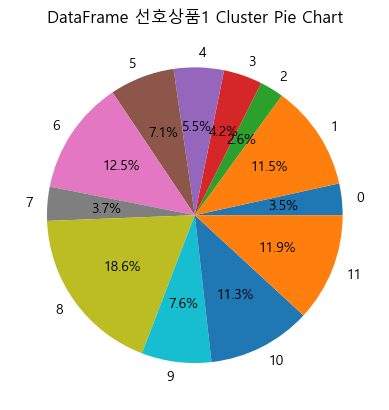

In [120]:
make_pie(cluster2, "선호상품1")